# Loan Approval Model

### Hypothesis
Some of my inital thoughts around the topic and data

Applicants are more likely to be approved when: 
- Have a credit history
- Loan Amt : Income ratio is low
- Less dependents
- Married

### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import math

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import set_config

import pickle

import json

### Functions

In [7]:
def hist(x):
    "returns a widget for histplot"
    return sns.histplot(df[x], kde=True, stat='density', linewidth=0)


## EDA

In [3]:
df = pd.read_csv("../../data/data.csv") 
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [5]:
# lets see what the skew is on these columns
df.skew(axis=0, skipna=True)

/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


ApplicantIncome      6.539513
CoapplicantIncome    7.491531
LoanAmount           2.677552
Loan_Amount_Term    -2.362414
Credit_History      -1.882361
dtype: float64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [11]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [8]:
# interactive plot for all columns to explore 
interact(hist, x=df.dtypes[df.dtypes != 'object'].index)

interactive(children=(Dropdown(description='x', options=('ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',…

<function __main__.hist(x)>

In [12]:
# lets check for class imbalance
df.groupby('Loan_Status').agg({'Loan_Status':'count'})

,Loan_Status
Loan_Status,
N,192
Y,422


#### Notes from EDA: 
- lots of missing values
- some numerical columns are skewed and not normal
- class status of 2:1 for Y:N

Lets look at just numeric columns

In [13]:
numerics =['int', 'float']
df_numeric = df.select_dtypes(include=numerics)
df_numeric.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849,0.0,NaN,360.0,1.0
1,4583,1508.0,128.0,360.0,1.0
2,3000,0.0,66.0,360.0,1.0
3,2583,2358.0,120.0,360.0,1.0
4,6000,0.0,141.0,360.0,1.0


How many applicants have Credit History?

In [20]:
df_numeric.groupby(by=['Credit_History'], 
                   dropna=False).agg(
                       C_H_count = ('ApplicantIncome', 'count'),
                       LoanAmt_mean=('LoanAmount', 'mean'),
                       LoanAmt_median=('LoanAmount', 'median')
                   )

,C_H_count,LoanAmt_mean,LoanAmt_median
Credit_History,,,
0.0,89,146.717647,125.0
1.0,475,144.786026,128.0
NaN,50,161.081633,130.0


In [22]:
interact(hist,
         x=df_numeric.dtypes[df_numeric.dtypes != 'object'].index
        )
# observe that most coapplicant incomes are 0 
# which makes sense as many people ether dont have a coa-applicant (maybe then 0) or there co applicant doesnt have an income

interactive(children=(Dropdown(description='x', options=('ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',…

<function __main__.hist(x)>

Lets look at categorical (nominal) variables

In [23]:
categorical = ['object']
df_categorical = df.select_dtypes(categorical)
df_categorical.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,Urban,Y
4,LP001008,Male,No,0,Graduate,No,Urban,Y


In [24]:
df_categorical.nunique()
# shows the unique values per column

Loan_ID          614
Gender             2
Married            2
Dependents         4
Education          2
Self_Employed      2
Property_Area      3
Loan_Status        2
dtype: int64

In [25]:
# exclude loan_id column for continued exploration
df_categorical.drop(columns='Loan_ID').groupby(by='Dependents', dropna=False).agg({'Dependents':'count'})
# can see most applicants have 0 dependents

,Dependents
Dependents,
0,345
1,102
2,101
3+,51
NaN,0


In [27]:
# interactive widget where you can click through dif columns to explore freqency of each class
def count_unique(x):
    return df_categorical.drop(columns='Loan_ID').groupby(by=x, dropna=False).agg({'Loan_Status':'count'})

interact(count_unique,
         x=df_categorical.drop(columns='Loan_ID').columns
        )

interactive(children=(Dropdown(description='x', options=('Gender', 'Married', 'Dependents', 'Education', 'Self…

<function __main__.count_unique(x)>

In [30]:
# lets look at this distribution interactively
interact(hist, x=df.drop(columns='Loan_ID').columns)

interactive(children=(Dropdown(description='x', options=('Gender', 'Married', 'Dependents', 'Education', 'Self…

<function __main__.hist(x)>

Observations from iteractive widget: 
- More applicants are married
- Most applicant are Male 
- Most have no depenents
- Most have graduated from some form of education
- More are NOT self employed
- Property area is somewhat balanced, but most being Semiurban
- More were approved for their applied loan in this dataset

In [31]:
# lets take a look at outliers through iterative widget
def box(x):
    return sns.boxplot(df[x])

interact(box, x=df_numeric.columns)

interactive(children=(Dropdown(description='x', options=('ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',…

<function __main__.box(x)>

<AxesSubplot:xlabel='ApplicantIncome', ylabel='Density'>

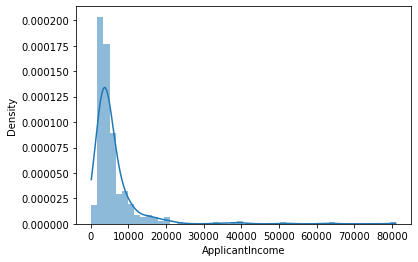

In [32]:
# look at dis of income by education

df_grad = df.loc[df['Education'] == 'Graduate']
df_nograd = df.loc[df['Education'] == 'Not Graduate']

sns.histplot(df_grad['ApplicantIncome'], kde=True, stat='density', linewidth=0, bins=50)

<AxesSubplot:xlabel='ApplicantIncome', ylabel='Density'>

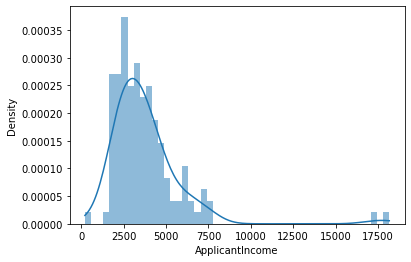

In [33]:
sns.histplot(df_nograd['ApplicantIncome'], kde=True, stat='density', linewidth=0, bins=50)

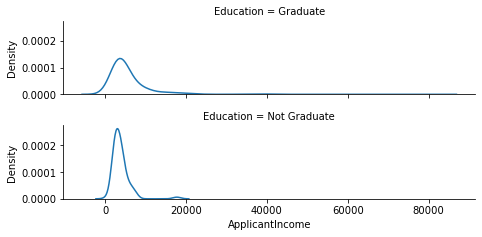

In [34]:
edu_types = df['Education'].value_counts().index
g = sns.FacetGrid(df, row='Education', row_order=edu_types, height=1.7, aspect=4)
g.map(sns.kdeplot, 'ApplicantIncome')

In [36]:
# pivot applicant income w geneder and loan amount
df.pivot_table(values=['ApplicantIncome', 'LoanAmount'], index=['Gender', 'Education'], aggfunc={'LoanAmount':['mean', 'median'], 'ApplicantIncome':'max'}, fill_value=0)

ApplicantIncome  LoanAmount       
                                max        mean median
Gender Education                                      
Female Graduate               19484  129.855556    113
       Not Graduate           18165  111.736842    102
Male   Graduate               81000  157.994490    136
       Not Graduate            7667  119.654206    115

## Data Cleaning

In [37]:
# missing values 
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [38]:
# filling nulls in gender w the mode
G_mode = df['Gender'].mode().values[0]
df['Gender'] = df['Gender'].fillna(G_mode)